In [31]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Parameter

In [32]:
as_week = 2023022

## Import 6 Dimension Summary data

In [33]:
conStr = 'NARUT_E01044451/v9VzR8xsuwp#tyTb@TDM-scan.dc2.true.th:1521/TDMDBPR'
conn = cx_Oracle.connect(conStr)
print('TDMDBPR : Connected')
cur = conn.cursor()

v_week = (as_week, )


try:
    print(f'\nExecute query as Week {v_week[0]}...')

    sqlTxt = """
        WITH W_VAR (AS_OF_WK) AS 
        ( 
            SELECT :1 AS AS_OF_WK FROM DUAL 
        ) 
        , W_TMP_PERIOD (TM_KEY_YR, TM_KEY_QTR, TM_KEY_MTH, TM_KEY_WK, WK_DAY_START, WK_DAY_END) AS 
        ( 
            SELECT TM_KEY_YR, TM_KEY_QTR, TM_KEY_MTH, TM_KEY_WK, MIN(TM_KEY_DAY) AS WK_DAY_START, MAX(TM_KEY_DAY) AS WK_DAY_END 
            FROM GEOSPCAPPO.AGG_PERFORMANCE_NEWCO NOLOCK 
            WHERE TM_KEY_WK <= (SELECT AS_OF_WK FROM W_VAR) 
            GROUP BY TM_KEY_YR, TM_KEY_QTR, TM_KEY_MTH, TM_KEY_WK 
        ) 
        SELECT * 
        FROM ( 
            SELECT TM_KEY_MTH, TM_KEY_WK, CENTER, METRIC_GRP, COMP_CD, PRODUCT_GRP, METRIC_CD, METRIC_NAME, DIMENSION_KPI_FLAG, BG_FLAG--, METRIC_NAME_GROUP 
                , AGG_TYPE, RR_IND, GRY_IND, UOM, PERIOD 
                , CAST(SUM(ACTUAL_AGG) AS DECIMAL(18,2)) AS ACTUAL_AGG 
                , CAST(SUM(TARGET_AGG) AS DECIMAL(18,2)) AS TARGET_AGG 
                , MAX(PPN_TM) AS PPN_TM 
            FROM ( 
                SELECT TM_KEY_MTH, TM_KEY_WK, TM_KEY_DAY, CENTER, METRIC_GRP, COMP_CD, PRODUCT_GRP, METRIC_CD, METRIC_NAME 
                    , CASE 	WHEN ( METRIC_CD IN ('DNEC10006', 'TNEC10002', 'TNEC20002') --NETWORK EXPERIENCE 
                                OR METRIC_CD IN ('B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142') --BUSINESS GROWTH 
                                OR METRIC_CD IN ('DSER21101', 'DSER22101', 'TSER21101', 'TSER22101', 'TSER23101', 'DB2S000200', 'DB1S000200', 'TB2S000200', 'TB1S000200', 'TSER13100', 'TSER14100') --CUSTOMER RETENTION & EXPERIENCE 
                                OR METRIC_CD IN ('TNSC00011', 'TNSC00013', 'TNSC00087', 'TNSC00101', 'TNSC00144', 'TNSC00020', 'TNSC00130') --NEW S-CURVE 
                                --COST & PRODUCTIVITY (Unknown ?) 
                                OR METRIC_CD IN ('DIS10007', 'DIS10011', 'DIS10001') --DIGITALIZATION 
                            ) THEN 'Y' ELSE 'N' END DIMENSION_KPI_FLAG 
                    , CASE 	WHEN METRIC_CD IN ('B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142') --BUSINESS GROWTH 
                            THEN 'Y' ELSE 'N' END BG_FLAG 
                    , METRIC_NAME_GROUP, PPN_TM, AGG_TYPE, RR_IND, GRY_IND, UOM, PERIOD, ACTUAL_AGG, TARGET_AGG 
                FROM GEOSPCAPPO.AGG_PERFORMANCE_NEWCO NOLOCK 
                WHERE TM_KEY_DAY IN (SELECT WK_DAY_END FROM W_TMP_PERIOD) 
                AND AREA_TYPE = 'P' 
            ) A 
            GROUP BY TM_KEY_MTH, TM_KEY_WK, CENTER, METRIC_GRP, COMP_CD, PRODUCT_GRP, METRIC_CD, METRIC_NAME, DIMENSION_KPI_FLAG, BG_FLAG, AGG_TYPE, RR_IND, GRY_IND, UOM, PERIOD 
        ) B 
    """
    
    cur.execute(sqlTxt, v_week)

    print(f'\nDone !!!')

    rows = cur.fetchall()
    
    df = pd.DataFrame.from_records(rows, columns=[x[0] for x in cur.description])


except cx_Oracle.DatabaseError as e:
    print(f'Error with Oracle : {e}')


finally:
    cur.close()
    conn.close()
    print('\nTDMDBPR : Disconnected')

TDMDBPR : Connected

Execute query as Week 2023022...

Done !!!

TDMDBPR : Disconnected


In [34]:
df.shape

(8384, 18)

In [35]:
df.tail(3)

,TM_KEY_MTH,TM_KEY_WK,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,DIMENSION_KPI_FLAG,BG_FLAG,AGG_TYPE,RR_IND,GRY_IND,UOM,PERIOD,ACTUAL_AGG,TARGET_AGG,PPN_TM
8381,202305,2023022,Sales & Revenue,Sales,TRUE,Postpaid,TB2S000102,With Device (Incd MNP) : TMH,N,N,S,1,GYR,subs,M,47141.00,NaN,2023-06-06 13:50:56
8382,202303,2023012,Customer Service Experience & Retention,Experience,TRUE,All Services,TSER02501,iCSAT (TopBox) : TRUE,N,N,N,0,GYR,%,M,84.08,85.0,2023-06-06 13:50:56
8383,202304,2023014,Customer Service Experience & Retention,Experience,TRUE,All Services,TSER02501,iCSAT (TopBox) : TRUE,N,N,N,0,GYR,%,M,83.02,85.0,2023-06-06 13:50:56


## Generate Rawdata as CSV file

In [38]:
op_raw_file = f'Raw-Agg Perf_Wk {as_week}'

df.to_csv(f'{op_raw_file}.csv', index=False, encoding='utf-8')

print(f'\n"{op_raw_file}.csv" is generated')


"Raw-Agg Perf_Wk 2023022.csv" is generated


## Business Growth Data prep

In [39]:
# df_bg = df[(df['CENTER'] == 'Sales & Revenue') & (df['BG_FLAG'] == 'Y')]
# df_bg = df[(df['BG_FLAG'] == 'Y') | ('METRIC_NAME' == 'TDG Revenue (Performance View)')]

data_src = f'Raw-Agg Perf_Wk {as_week}.csv'
df_raw = pd.read_csv(data_src)
bg_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"
df_bg = df_raw[df_raw['METRIC_CD'].isin(bg_cd_list)]
df_bg.head(3)

,TM_KEY_MTH,TM_KEY_WK,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,DIMENSION_KPI_FLAG,BG_FLAG,AGG_TYPE,RR_IND,GRY_IND,UOM,PERIOD,ACTUAL_AGG,TARGET_AGG,PPN_TM
482,202303,2023010,Sales & Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,Y,Y,S,0,GYR,baht,M,2.542705e+09,2.560220e+09,2023-06-06 13:50:56
483,202304,2023014,Sales & Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,Y,Y,S,0,GYR,baht,M,1.796362e+09,1.824547e+09,2023-06-06 13:50:56
484,202305,2023019,Sales & Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,Y,Y,S,0,GYR,baht,M,3.149006e+09,3.154019e+09,2023-06-06 13:50:56


In [40]:
df_bg.shape

(80, 18)

In [41]:
df_bg['METRIC_NAME'].unique()

array(['Postpaid Revenue', 'Prepaid Revenue',
       'TDG Revenue (Performance View)', 'TOL Revenue', 'TVS Revenue'],
      dtype=object)

## Weekly Aggregate

In [42]:
df_bg_agg_actual_wk = pd.DataFrame(df_bg.groupby(['TM_KEY_WK', 'METRIC_CD', 'METRIC_NAME'])['ACTUAL_AGG'].sum().reset_index())
df_bg_agg_actual_wk.rename(columns={'ACTUAL_AGG': 'AGG'}, inplace=True)
df_bg_agg_actual_wk['MEASURE'] = 'ACTUAL'

df_bg_agg_target_wk = pd.DataFrame(df_bg.groupby(['TM_KEY_WK', 'METRIC_CD', 'METRIC_NAME'])['TARGET_AGG'].sum().reset_index())
df_bg_agg_target_wk.rename(columns={'TARGET_AGG': 'AGG'}, inplace=True)
df_bg_agg_target_wk['MEASURE'] = 'TARGET'

df_bg_agg_wk = pd.concat([df_bg_agg_actual_wk, df_bg_agg_target_wk])
df_bg_agg_wk['AGG'] = df_bg_agg_wk['AGG'] / 1000000
df_bg_agg_wk.head()

,TM_KEY_WK,METRIC_CD,METRIC_NAME,AGG,MEASURE
0,2023009,B1R000100,Prepaid Revenue,669.901008,ACTUAL
1,2023009,B2R000100,Postpaid Revenue,1157.226110,ACTUAL
2,2023009,TB3R000100,TOL Revenue,189.713166,ACTUAL
3,2023009,TB4R000100,TVS Revenue,42.430646,ACTUAL
4,2023009,TNSC00142,TDG Revenue (Performance View),0.000000,ACTUAL


In [43]:
df_bg_agg_wk_pivot = df_bg_agg_wk.pivot(index=['TM_KEY_WK', 'MEASURE'], columns=['METRIC_CD', 'METRIC_NAME'], values='AGG')
# df_bg_agg_wk_pivot

output_data = df_bg_agg_wk_pivot.T
output_data.round(2)

TM_KEY_WK                                  2023009           2023010           \
MEASURE                                     ACTUAL   TARGET   ACTUAL   TARGET   
METRIC_CD  METRIC_NAME                                                          
B1R000100  Prepaid Revenue                  669.90   626.22  1489.02  1464.92   
B2R000100  Postpaid Revenue                1157.23  1165.61  2542.70  2560.22   
TB3R000100 TOL Revenue                      189.71   205.17   495.35   531.75   
TB4R000100 TVS Revenue                       42.43    47.56    90.13   100.81   
TNSC00142  TDG Revenue (Performance View)     0.00     0.00   573.74   522.00   

TM_KEY_WK                                  2023011           2023012           \
MEASURE                                     ACTUAL   TARGET   ACTUAL   TARGET   
METRIC_CD  METRIC_NAME                                                          
B1R000100  Prepaid Revenue                 2265.82  2281.46  3055.20  3090.84   
B2R000100  Postpaid Revenue                4320.11  4365.50  5690.43  5739.95   
TB3R000100 TOL Revenue                      952.87  1020.47  1246.04  1332.36   
TB4R000100 TVS Revenue                      171.66   191.37   223.40   249.18   
TNSC00142  TDG Revenue (Performance View)   573.74   522.00   573.74   522.00   

TM_KEY_WK                                  2023013           ...  2023018  \
MEASURE                                     ACTUAL   TARGET  ...   ACTUAL   
METRIC_CD  METRIC_NAME                                       ...            
B1R000100  Prepaid Revenue                 3957.43  3952.69  ...   881.98   
B2R000100  Postpaid Revenue                7480.29  7566.68  ...  1598.88   
TB3R000100 TOL Revenue                     1594.48  1704.09  ...   302.08   
TB4R000100 TVS Revenue                      314.92   461.17  ...    53.96   
TNSC00142  TDG Revenue (Performance View)   573.74   522.00  ...   561.00   

TM_KEY_WK                                           2023019           2023020  \
MEASURE                                     TARGET   ACTUAL   TARGET   ACTUAL   
METRIC_CD  METRIC_NAME                                                          
B1R000100  Prepaid Revenue                  862.25  1696.81  1682.65  2506.47   
B2R000100  Postpaid Revenue                1601.33  3149.01  3154.02  4514.36   
TB3R000100 TOL Revenue                      317.30   665.23   702.80   972.05   
TB4R000100 TVS Revenue                       59.56   101.82   131.08   154.89   
TNSC00142  TDG Revenue (Performance View)   503.00   561.00   503.00   561.00   

TM_KEY_WK                                           2023021           2023022  \
MEASURE                                     TARGET   ACTUAL   TARGET   ACTUAL   
METRIC_CD  METRIC_NAME                                                          
B1R000100  Prepaid Revenue                 2502.40  3324.17  3317.08  4147.71   
B2R000100  Postpaid Revenue                4526.16  6263.75  6300.31  7426.68   
TB3R000100 TOL Revenue                     1032.97  1272.30  1516.00  1272.30   
TB4R000100 TVS Revenue                      191.37   234.78   265.78   236.22   
TNSC00142  TDG Revenue (Performance View)   503.00   561.00   503.00   542.00   

TM_KEY_WK                                           
MEASURE                                     TARGET  
METRIC_CD  METRIC_NAME                              
B1R000100  Prepaid Revenue                 4067.08  
B2R000100  Postpaid Revenue                7522.73  
TB3R000100 TOL Revenue                     1516.00  
TB4R000100 TVS Revenue                      413.62  
TNSC00142  TDG Revenue (Performance View)   503.00  

[5 rows x 28 columns]

## Generate Output File (BG summary for 6 dimension)

In [44]:
output_file = f'{op_raw_file.replace("Raw-Agg", "BG")}.xlsx'

output_data.to_excel(output_file)

print(f'\n"{output_file}" is generated')


"BG Perf_Wk 2023022.xlsx" is generated


## Visualization

In [51]:
''' BG rawdata '''
df_bg_agg = pd.DataFrame(df_bg.groupby(['TM_KEY_MTH', 'TM_KEY_WK', 'METRIC_CD', 'METRIC_NAME']).agg({'ACTUAL_AGG': 'sum', 'TARGET_AGG': 'sum'}).reset_index())
df_bg_agg['ACTUAL_AGG'] = df_bg_agg['ACTUAL_AGG'] / 1000000
df_bg_agg['TARGET_AGG'] = df_bg_agg['TARGET_AGG'] / 1000000
df_bg_agg.tail()

,TM_KEY_MTH,TM_KEY_WK,METRIC_CD,METRIC_NAME,ACTUAL_AGG,TARGET_AGG
75,202306,2023022,B1R000100,Prepaid Revenue,413.968297,381.498873
76,202306,2023022,B2R000100,Postpaid Revenue,843.754244,894.674980
77,202306,2023022,TB3R000100,TOL Revenue,0.000000,0.000000
78,202306,2023022,TB4R000100,TVS Revenue,0.000000,0.000000
79,202306,2023022,TNSC00142,TDG Revenue (Performance View),0.000000,0.000000


In [46]:
''' Rawdata by week '''
df_bg_wk = df_bg_agg.groupby('TM_KEY_WK').sum()[['ACTUAL_AGG','TARGET_AGG']].reset_index()
df_bg_wk['%ACHIEVE'] = (df_bg_wk['ACTUAL_AGG'] / df_bg_wk['TARGET_AGG']) * 100
df_bg_wk['ACTUAL_DIFF'] = df_bg_wk['ACTUAL_AGG'].diff().fillna(0)
df_bg_wk['LAST_WK_ACTUAL'] = df_bg_wk['ACTUAL_AGG'] - df_bg_wk['ACTUAL_DIFF']
# df_bg_wk['FF_NULL_TEST'] = df_bg_wk['ACTUAL_DIFF'].fillna(0)

x = df_bg_wk['TM_KEY_WK'].apply(str).str[5:]
x_axis = np.arange(len(x))
y_act = df_bg_wk['ACTUAL_AGG'].round(2)
y_tgt = df_bg_wk['TARGET_AGG'].round(2)
y_ach = df_bg_wk['%ACHIEVE'].round(2)
y_diff = df_bg_wk['ACTUAL_DIFF'].round(2)
y_last_act = df_bg_wk['LAST_WK_ACTUAL'].round(2)
df_bg_wk.tail()

C:\Users\Narut4\AppData\Local\Temp\ipykernel_29648\132538584.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bg_wk = df_bg_agg.groupby('TM_KEY_WK').sum()[['ACTUAL_AGG','TARGET_AGG']].reset_index()


,TM_KEY_WK,ACTUAL_AGG,TARGET_AGG,%ACHIEVE,ACTUAL_DIFF,LAST_WK_ACTUAL
9,2023018,3397.902697,3343.425303,101.629389,-9035.293270,12433.195967
10,2023019,6173.865841,6173.556237,100.005015,2775.963144,3397.902697
11,2023020,8708.772063,8755.904201,99.461710,2534.906222,6173.865841
12,2023021,11656.004349,11902.166751,97.931785,2947.232286,8708.772063
13,2023022,13624.912280,14022.427157,97.165149,1968.907931,11656.004349


## Bar Chart

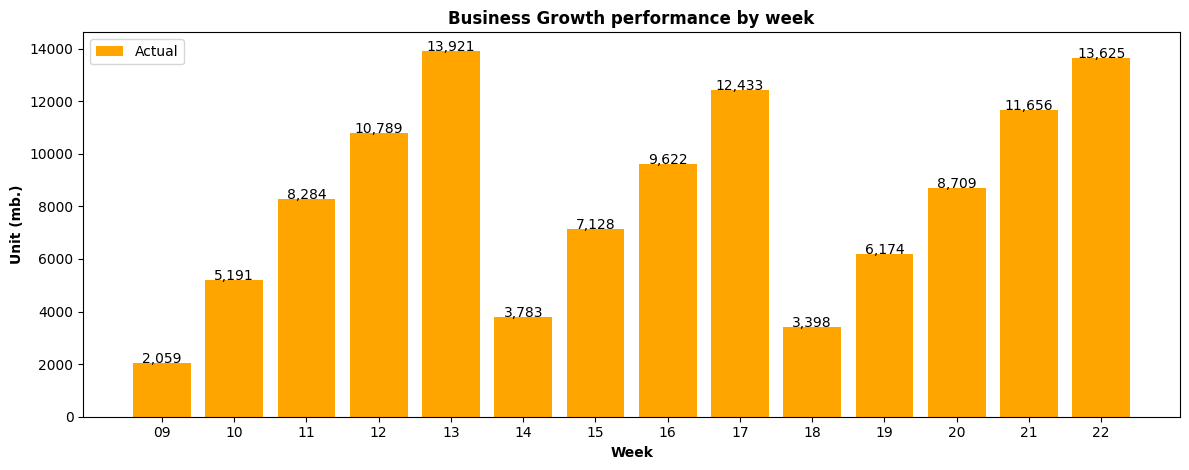

In [47]:
plt.figure().set_figwidth(12)

plt.bar(x_axis, y_act, label='Actual', color='orange')
for i in x_axis:    
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i], y_act[i]), ha='center')
    # plt.annotate(str(y_act[i]), xy=(x_axis[i], y_act[i]))
plt.xticks(x_axis, x)
plt.xlabel('Week', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title('Business Growth performance by week', fontdict={'fontweight': 'bold'})
plt.legend()

plt.tight_layout()
plt.show()

## Plot Chart

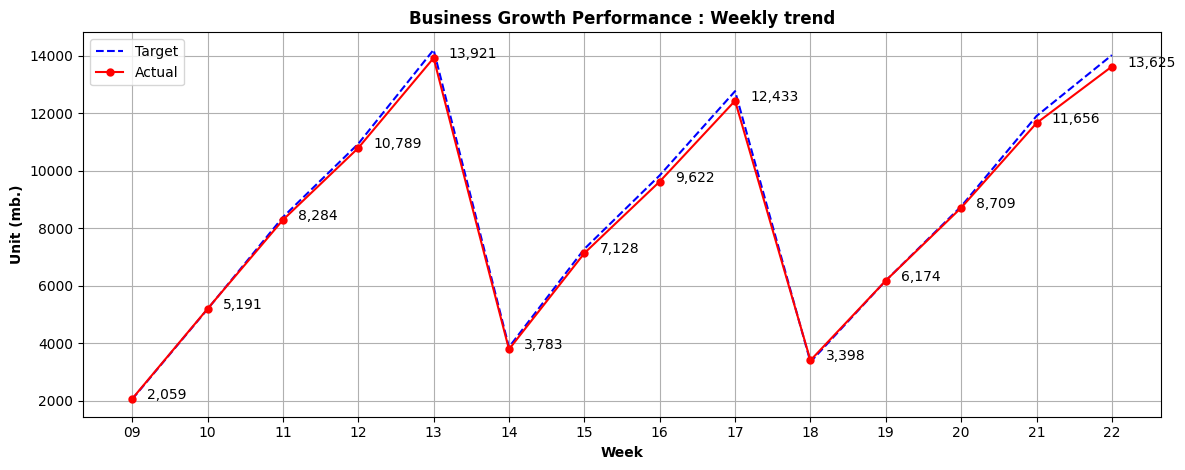

In [48]:
plt.figure().set_figwidth(12)

# plt.plot(x_axis, y_tgt, marker='.', markeredgewidth=3, label='Target', color='blue')
plt.plot(x_axis, y_tgt, 'b--', markeredgewidth=3, label='Target')
# plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, markeredgecolor='red')
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='red')
for i in x_axis:
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i]+0.2, y_act[i]))
# plt.xticks(x_axis, rotation='horizontal')
plt.xticks(x_axis, x)
plt.xlabel('Week', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title('Business Growth Performance : Weekly trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()